<a href="https://colab.research.google.com/github/mangaorphy/Formative2-Malaria-Diagnosis-CNN-Transfer-Learning-Group-5/blob/main/InceptionV3_CNN_%26_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

# Malaria Diagnosis Using InceptionV3 CNN & Transfer Learning
**Owner:** Daniel Kudum  
**Course:** Formative 2 – Malaria Diagnosis CNN + Transfer Learning (Group Assignment)    

## Introduction
This notebook presents the work of **Daniel Kudum** on building and evaluating Convolutional Neural Network (CNN) models for automated **malaria diagnosis** using microscopic cell images. The primary focus of this model is the **InceptionV3 architecture**, a pretrained deep learning model that leverages transfer learning for improved performance on limited medical image datasets.  

The notebook covers:  
1. Data preparation and augmentation  
2. Building the InceptionV3-based CNN model  
3. Running multiple experiments with systematic hyperparameter tuning  
4. Visual evaluation including:  
   - Learning curves (accuracy and loss)  
   - Confusion matrices  
   - ROC/AUC curves  
5. Classification metrics such as **accuracy, precision, recall, and F1-score**  
6. Discussion of results and performance analysis  

The goal is to demonstrate the power of transfer learning with InceptionV3 for **robust and accurate malaria detection**, while adhering to rigorous evaluation standards and providing clear visual insights into model performance.


## Configuration

In [1]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Importing Libraries

In [2]:
# Import additional libraries for evaluation and visualization
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import json
import gc  # Garbage collection for memory management

In [5]:
# Importing basic libraries
import os
import random
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Importing the Keras/TensorFlow libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

## Prepare DataSet

# Download the data for Malaria cells

In [6]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 15:26:26--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 18.65.39.75, 18.65.39.125, 18.65.39.80, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|18.65.39.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   354MB/s    in 1.0s    

2025-10-05 15:26:27 (354 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


# Define the useful paths for data accessibility

In [7]:
# Define the useful paths for data accessibility (updated for local environment)
base_dir = '/content/cell_images'
parasitized_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir = os.path.join(base_dir, 'Uninfected')

# Create directories for train/validation/test splits
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Base directory: {base_dir}")
print(f"Parasitized images directory: {parasitized_dir}")
print(f"Uninfected images directory: {uninfected_dir}")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

# Verify data directories exist
print(f"\nParasitized folder exists: {os.path.exists(parasitized_dir)}")
print(f"Uninfected folder exists: {os.path.exists(uninfected_dir)}")

Base directory: /content/cell_images
Parasitized images directory: /content/cell_images/Parasitized
Uninfected images directory: /content/cell_images/Uninfected
Training directory: /content/cell_images/train
Validation directory: /content/cell_images/validation
Test directory: /content/cell_images/test

Parasitized folder exists: True
Uninfected folder exists: True


# Data Exploration: Check dataset statistics

In [8]:
# Data Exploration: Check dataset statistics
print("=== DATASET EXPLORATION ===")

# Count images in each directory
parasitized_files = os.listdir(parasitized_dir)
uninfected_files = os.listdir(uninfected_dir)

# Filter only image files
parasitized_files = [f for f in parasitized_files if f.endswith(('.png', '.jpg', '.jpeg'))]
uninfected_files = [f for f in uninfected_files if f.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total Parasitized images: {len(parasitized_files)}")
print(f"Total Uninfected images: {len(uninfected_files)}")
print(f"Total images: {len(parasitized_files) + len(uninfected_files)}")
print(f"Dataset is balanced: {len(parasitized_files) == len(uninfected_files)}")

=== DATASET EXPLORATION ===
Total Parasitized images: 13779
Total Uninfected images: 13779
Total images: 27558
Dataset is balanced: True



=== PARASITIZED IMAGES ANALYSIS ===


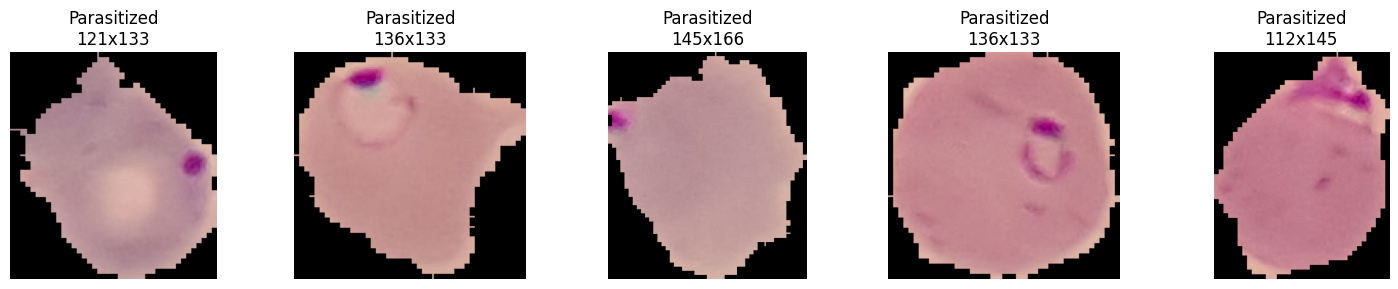

Sample sizes (W x H): [(121, 133), (136, 133), (145, 166), (136, 133), (112, 145)]
Width range: 112 - 145
Height range: 133 - 166

=== UNINFECTED IMAGES ANALYSIS ===


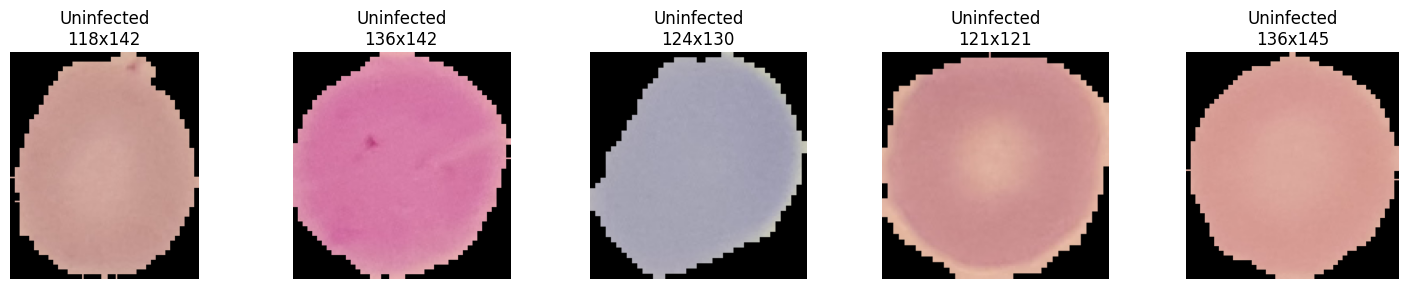

Sample sizes (W x H): [(118, 142), (136, 142), (124, 130), (121, 121), (136, 145)]
Width range: 118 - 136
Height range: 121 - 145


In [9]:
import shutil

# Analyze image properties and display sample images
def analyze_images(directory, class_name, num_samples=5):
    """Analyze image properties and display samples"""
    print(f"\n=== {class_name.upper()} IMAGES ANALYSIS ===")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
    sizes = []

    plt.figure(figsize=(15, 3))

    for i, filename in enumerate(files):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        sizes.append(img.size)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'{class_name}\n{img.size[0]}x{img.size[1]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print size statistics
    widths = [size[0] for size in sizes]
    heights = [size[1] for size in sizes]

    print(f"Sample sizes (W x H): {sizes}")
    print(f"Width range: {min(widths)} - {max(widths)}")
    print(f"Height range: {min(heights)} - {max(heights)}")

    return sizes

# Analyze both classes
parasitized_sizes = analyze_images(parasitized_dir, "Parasitized")
uninfected_sizes = analyze_images(uninfected_dir, "Uninfected")

# Comprehensive image size analysis

Analyzing image dimensions across dataset...

Analyzing all Parasitized image sizes...


Processing Parasitized: 100%|██████████| 1000/1000 [00:00<00:00, 19342.94it/s]



Analyzing all Uninfected image sizes...


Processing Uninfected: 100%|██████████| 1000/1000 [00:00<00:00, 20673.31it/s]


=== IMAGE SIZE STATISTICS ===
Total images analyzed: 2000
Width  - Min: 61, Max: 238, Mean: 131.8
Height - Min: 61, Max: 235, Mean: 133.0


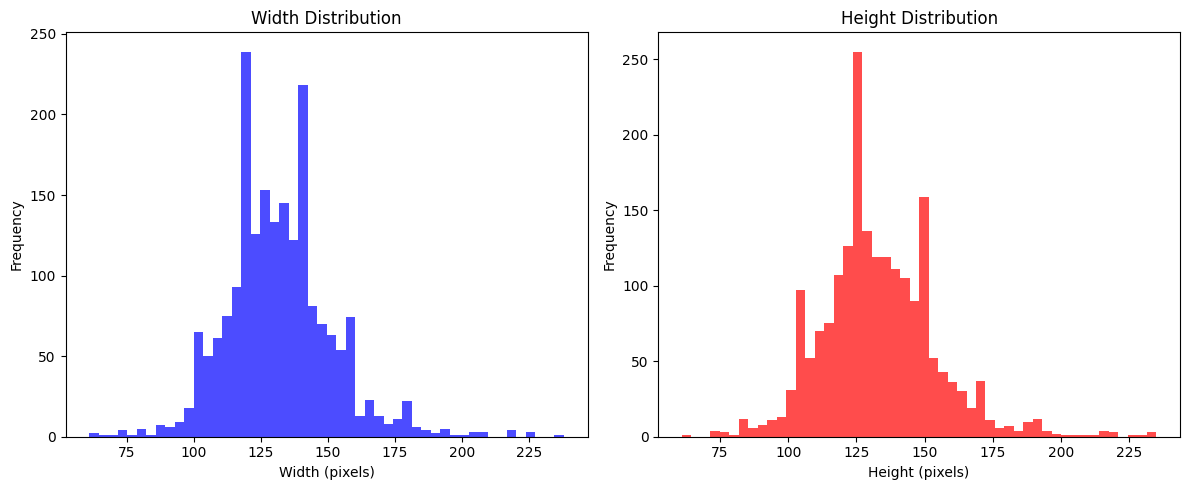

In [10]:
# Comprehensive image size analysis
def get_all_image_sizes(directory, class_name):
    """Get sizes of all images in directory"""
    print(f"\nAnalyzing all {class_name} image sizes...")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sizes = []

    for filename in tqdm(files[:1000], desc=f"Processing {class_name}"): # Sample first 1000 for speed
        try:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            sizes.append((img.size[0], img.size[1]))  # (width, height)
            img.close()
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    return sizes

# Analyze image sizes
print("Analyzing image dimensions across dataset...")
parasitized_all_sizes = get_all_image_sizes(parasitized_dir, "Parasitized")
uninfected_all_sizes = get_all_image_sizes(uninfected_dir, "Uninfected")

# Combine and analyze
all_sizes = parasitized_all_sizes + uninfected_all_sizes
widths = [size[0] for size in all_sizes]
heights = [size[1] for size in all_sizes]

print(f"\n=== IMAGE SIZE STATISTICS ===")
print(f"Total images analyzed: {len(all_sizes)}")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")

# Plot size distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, alpha=0.7, color='blue')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, alpha=0.7, color='red')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Configuration for data preprocessing

## Data Splitting and Directory Setup

In this section, we will define the parameters for splitting the dataset into training, validation, and testing sets. We will also create the necessary directory structure to organize the images for each split.

This cell defines the key parameters used for preparing the image data for the deep learning model:

- `IMG_SIZE`: This sets the target size (width and height) to which all images will be resized. Standardizing image size is essential for feeding data into a convolutional neural network.
- `BATCH_SIZE`: This determines the number of samples that will be processed in each training step. Larger batch sizes can sometimes lead to faster training but may require more memory.
- `TRAIN_SPLIT`, `VAL_SPLIT`, `TEST_SPLIT`: These define the proportions of the dataset that will be allocated to the training, validation, and testing sets, respectively. A common split is 70% for training, 15% for validation, and 15% for testing, as used here.

The code also calls a function `create_directories` to set up the necessary folder structure within the `cell_images` directory to hold the images for each split (train, validation, and test) and their respective classes (Parasitized and Uninfected). This organization is crucial for using data generators effectively.

In [11]:
# Configuration for data preprocessing
IMG_SIZE = 64  # Standard size for malaria cell images
BATCH_SIZE = 32
TRAIN_SPLIT = 0.7  # 70% for training
VAL_SPLIT = 0.15   # 15% for validation
TEST_SPLIT = 0.15  # 15% for testing

print(f"Image target size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Data splits - Train: {TRAIN_SPLIT*100}%, Val: {VAL_SPLIT*100}%, Test: {TEST_SPLIT*100}%")

# Create directories if they don't exist
def create_directories():
    dirs_to_create = [
        train_dir, val_dir, test_dir,
        os.path.join(train_dir, 'Parasitized'),
        os.path.join(train_dir, 'Uninfected'),
        os.path.join(val_dir, 'Parasitized'),
        os.path.join(val_dir, 'Uninfected'),
        os.path.join(test_dir, 'Parasitized'),
        os.path.join(test_dir, 'Uninfected')
    ]

    for directory in dirs_to_create:
        os.makedirs(directory, exist_ok=True)
        print(f"Created/verified directory: {directory}")

create_directories()

Image target size: 64x64
Batch size: 32
Data splits - Train: 70.0%, Val: 15.0%, Test: 15.0%
Created/verified directory: /content/cell_images/train
Created/verified directory: /content/cell_images/validation
Created/verified directory: /content/cell_images/test
Created/verified directory: /content/cell_images/train/Parasitized
Created/verified directory: /content/cell_images/train/Uninfected
Created/verified directory: /content/cell_images/validation/Parasitized
Created/verified directory: /content/cell_images/validation/Uninfected
Created/verified directory: /content/cell_images/test/Parasitized
Created/verified directory: /content/cell_images/test/Uninfected


## Split data into train/validation/test

In [12]:
# Function to split data into train/validation/test sets
def split_and_copy_data():
    """Split data and copy to respective directories"""

    # Get all image files for each class
    parasitized_files = [f for f in os.listdir(parasitized_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_files = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Splitting {len(parasitized_files)} parasitized images...")
    print(f"Splitting {len(uninfected_files)} uninfected images...")

    # Shuffle the files
    parasitized_files = shuffle(parasitized_files, random_state=42)
    uninfected_files = shuffle(uninfected_files, random_state=42)

    def split_files(files, class_name):
        """Split files for a single class"""
        n_total = len(files)
        n_train = int(n_total * TRAIN_SPLIT)
        n_val = int(n_total * VAL_SPLIT)

        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        print(f"{class_name} split: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

        return train_files, val_files, test_files

    # Split files for each class
    para_train, para_val, para_test = split_files(parasitized_files, "Parasitized")
    uninf_train, uninf_val, uninf_test = split_files(uninfected_files, "Uninfected")

    # Copy files to respective directories
    def copy_files(file_list, source_dir, dest_dir, class_name, split_name):
        """Copy files from source to destination"""
        dest_class_dir = os.path.join(dest_dir, class_name)

        for filename in tqdm(file_list, desc=f"Copying {class_name} {split_name}"):
            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(dest_class_dir, filename)

            # Only copy if destination doesn't exist
            if not os.path.exists(dst_path):
                shutil.copy2(src_path, dst_path)

    # Copy all files
    copy_files(para_train, parasitized_dir, train_dir, 'Parasitized', 'train')
    copy_files(para_val, parasitized_dir, val_dir, 'Parasitized', 'val')
    copy_files(para_test, parasitized_dir, test_dir, 'Parasitized', 'test')

    copy_files(uninf_train, uninfected_dir, train_dir, 'Uninfected', 'train')
    copy_files(uninf_val, uninfected_dir, val_dir, 'Uninfected', 'val')
    copy_files(uninf_test, uninfected_dir, test_dir, 'Uninfected', 'test')

    print("Data splitting complete!")

    return {
        'train': {'parasitized': len(para_train), 'uninfected': len(uninf_train)},
        'val': {'parasitized': len(para_val), 'uninfected': len(uninf_val)},
        'test': {'parasitized': len(para_test), 'uninfected': len(uninf_test)}
    }

# Execute the splitting (only if directories are empty)
train_para_dir = os.path.join(train_dir, 'Parasitized')
if len(os.listdir(train_para_dir)) == 0:
    print("Performing data split...")
    split_stats = split_and_copy_data()
    print(f"\nFinal split statistics: {split_stats}")
else:
    print("Data already split, skipping...")

Performing data split...
Splitting 13779 parasitized images...
Splitting 13779 uninfected images...
Parasitized split: 9645 train, 2066 val, 2068 test
Uninfected split: 9645 train, 2066 val, 2068 test


Copying Uninfected test: 100%|██████████| 2068/2068 [00:00<00:00, 5453.50it/s]

Data splitting complete!

Final split statistics: {'train': {'parasitized': 9645, 'uninfected': 9645}, 'val': {'parasitized': 2066, 'uninfected': 2066}, 'test': {'parasitized': 2068, 'uninfected': 2068}}


## Data Augmentation and Preprocessing

Data augmentation is a technique used to artificially increase the size of the training dataset by creating modified versions of existing images. This helps to improve the model's ability to generalize and reduce overfitting.(Data Camp)

The code below sets up the data preprocessing pipeline, including data augmentation for the training set.

In [13]:
# Data augmentation and preprocessing pipeline setup
print("=== SETTING UP DATA PREPROCESSING PIPELINE ===")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize pixel values to [0,1]
    rotation_range=20,              # Random rotation
    width_shift_range=0.1,          # Random horizontal shift
    height_shift_range=0.1,         # Random vertical shift
    shear_range=0.1,                # Random shear transformation
    zoom_range=0.1,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=False,            # No vertical flip (cells have orientation)
    fill_mode='nearest'             # Fill pixels after transformation
)

# Validation and test data (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

print("✓ Data generators configured")
print("  - Training: with augmentation (rotation, shift, shear, zoom, flip)")
print("  - Validation/Test: only normalization")
print(f"  - Target image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")

=== SETTING UP DATA PREPROCESSING PIPELINE ===
✓ Data generators configured
  - Training: with augmentation (rotation, shift, shear, zoom, flip)
  - Validation/Test: only normalization
  - Target image size: 64x64
  - Batch size: 32


## Creating Data Generators

This cell utilizes the `ImageDataGenerator` to create data generators for the training, validation, and test sets. These generators are essential for efficiently loading and preprocessing images in batches during the model training process.

- The training generator (`train_generator`) applies the configured data augmentation techniques and normalization.
- The validation (`validation_generator`) and test (`test_generator`) generators only apply normalization, as augmentation is typically only used on the training data.

The `flow_from_directory` method is used to load images directly from the organized directory structure created earlier. Key parameters include:

- `target_size`: Resizes all images to the specified `IMG_SIZE`.
- `batch_size`: Defines the number of images per batch.
- `class_mode='binary'`: Indicates a binary classification problem (two classes).
- `shuffle=True` for training data to randomize the order of images in each epoch.
- `shuffle=False` for validation and test data to maintain consistent evaluation order.

Finally, the code converts the Keras generators to `tf.data.Dataset` objects and applies `prefetch` for optimized data loading during training.

In [14]:
# Create data generators from directories
print("Creating data generators from directories...")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize pixel values to [0,1]
    rotation_range=20,              # Random rotation
    width_shift_range=0.1,          # Random horizontal shift
    height_shift_range=0.1,         # Random vertical shift
    shear_range=0.1,                # Random shear transformation
    zoom_range=0.1,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=False,            # No vertical flip (cells have orientation)
    fill_mode='nearest'             # Fill pixels after transformation
)

# Validation and test data (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)


# Training data generator
train_generator_raw = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',            # Binary classification (0: Parasitized, 1: Uninfected)
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator_raw = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Test data generator
test_generator_raw = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Apply prefetch for optimized pipeline
AUTOTUNE = tf.data.AUTOTUNE

train_generator = tf.data.Dataset.from_generator(
    lambda: train_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)

validation_generator = tf.data.Dataset.from_generator(
    lambda: validation_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)

test_generator = tf.data.Dataset.from_generator(
    lambda: test_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)


print(f"\n✓ Data generators created successfully!")
# After converting to tf.data.Dataset, .samples, num_classes, and class_indices attributes are not available
# We will use the raw generators to get these details for printing
print(f"  - Training samples: {train_generator_raw.samples}")
print(f"  - Validation samples: {validation_generator_raw.samples}")
print(f"  - Test samples: {test_generator_raw.samples}")
print(f"  - Number of classes: {train_generator_raw.num_classes}")
print(f"  - Class indices: {train_generator_raw.class_indices}")


# Calculate steps per epoch
STEPS_PER_EPOCH = train_generator_raw.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator_raw.samples // BATCH_SIZE
TEST_STEPS = test_generator_raw.samples // BATCH_SIZE


print(f"\n✓ Steps per epoch calculated:")
print(f"  - Training steps per epoch: {STEPS_PER_EPOCH}")
print(f"  - Validation steps: {VALIDATION_STEPS}")
print(f"  - Test steps: {TEST_STEPS}")

Creating data generators from directories...
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead



✓ Data generators created successfully!
  - Training samples: 19290
  - Validation samples: 4132
  - Test samples: 4136
  - Number of classes: 2
  - Class indices: {'Parasitized': 0, 'Uninfected': 1}

✓ Steps per epoch calculated:
  - Training steps per epoch: 602
  - Validation steps: 129
  - Test steps: 129


# Visualize augmented training data samples

Visualizing 8 augmented training samples...


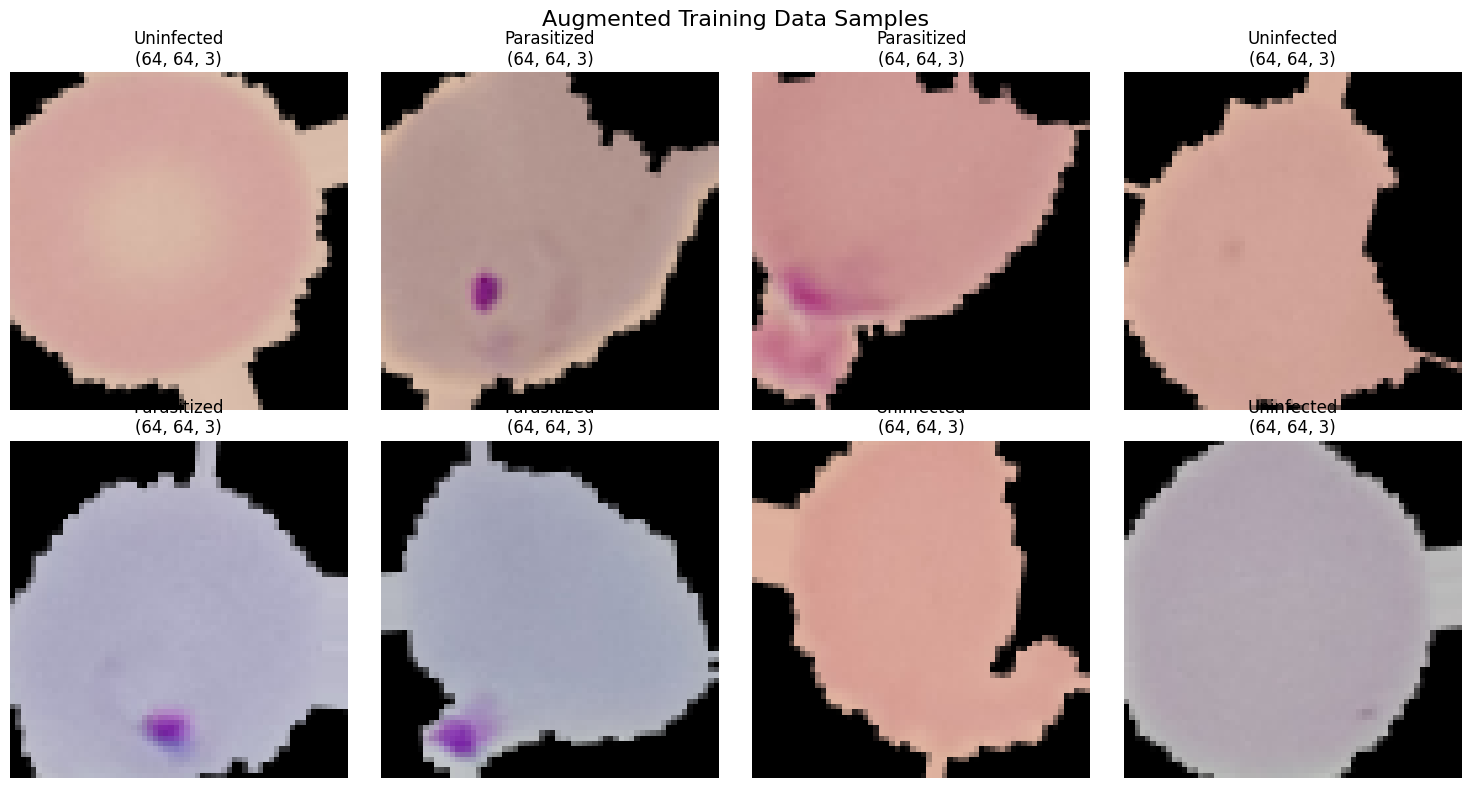

Sample batch shape: (32, 64, 64, 3)
Sample labels shape: (32,)
Pixel value range: [0.000, 0.887]


In [15]:
# Visualize augmented training data samples
def visualize_augmented_data(generator, num_samples=8):
    """Visualize samples from the data generator"""
    print(f"Visualizing {num_samples} augmented training samples...")

    # Get a batch of data by iterating over the dataset and taking one batch
    for sample_batch, sample_labels in generator.take(1):
        # Convert tensors to numpy arrays for visualization
        sample_batch = sample_batch.numpy()
        sample_labels = sample_labels.numpy()

        plt.figure(figsize=(15, 8))
        for i in range(min(num_samples, len(sample_batch))):
            plt.subplot(2, 4, i+1)

            # Display image
            img = sample_batch[i]
            plt.imshow(img)

            # Get class name
            class_name = "Uninfected" if sample_labels[i] == 1 else "Parasitized"
            plt.title(f'{class_name}\n{img.shape}')
            plt.axis('off')

        plt.suptitle('Augmented Training Data Samples', fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"Sample batch shape: {sample_batch.shape}")
        print(f"Sample labels shape: {sample_labels.shape}")
        print(f"Pixel value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

# Visualize training data
visualize_augmented_data(train_generator)

# InceptionV3 Transfer Learning Experimental Suite (3 Experiments)

**Goal:** Implement 3 transfer-learning experiments using InceptionV3 with different hyperparameters and fine-tuning strategies.  
Each experiment includes full evaluation: **accuracy, precision, recall, F1-score, ROC/AUC**, plus **learning curves** and **confusion matrices**.  
Finally, perform a comparative analysis and pick the best model.


In [18]:
# =============================================================================
# 🧠 InceptionV3 Transfer Learning Experimental Suite Setup
# =============================================================================
# Import InceptionV3 and additional libraries for comprehensive evaluation

from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import gc
import json

# Set style for better visualization
plt.style.use('default')
sns.set_palette("husl")

print("✅ Additional libraries imported successfully")
print("✅ Ready to build InceptionV3 transfer learning experiments")


✅ Additional libraries imported successfully
✅ Ready to build InceptionV3 transfer learning experiments


In [19]:
# Define 3 experimental configurations
experiments = [
    {
        'name': 'Experiment 1: Lower Learning Rate',
        'learning_rate': 0.0005,
        'optimizer': 'adam',
        'dropout_rate': 0.7,
        'dense_neurons': 256,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Reduced learning rate for more stable training and Increased regularization to prevent overfitting'
    },
    {
        'name': 'Experiment 2: Larger Dense Layer',
        'learning_rate': 0.001,
        'optimizer': 'sgd',
        'dropout_rate': 0.5,
        'dense_neurons': 512,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Increased model capacity with more neurons and Alternative optimizer with momentum'
    },
    {
        'name': 'Experiment 3: Fine-tuned ResNet50',
        'learning_rate': 0.0001,
        'optimizer': 'adam',
        'dropout_rate': 0.3,
        'dense_neurons': 256,
        'epochs': 30,
        'fine_tune': True,
        'description': 'Unfrozen top layers for fine-tuning'
    }
]

print(f"✓ Defined {len(experiments)} experimental configurations:")
for i, exp in enumerate(experiments, 1):
    print(f"  {i}. {exp['name']}")
    print(f"     {exp['description']}")

# Global variables to store results
experiment_results = []
all_histories = []

✓ Defined 3 experimental configurations:
  1. Experiment 1: Lower Learning Rate
     Reduced learning rate for more stable training and Increased regularization to prevent overfitting
  2. Experiment 2: Larger Dense Layer
     Increased model capacity with more neurons and Alternative optimizer with momentum
  3. Experiment 3: Fine-tuned ResNet50
     Unfrozen top layers for fine-tuning


#Model Definition: create_inception_model Function

This cell defines the create_inception_model function, which is responsible for building the InceptionV3 transfer learning model based on the specified configuration for each experiment.

Key aspects of this function include:

Loading the Pre-trained InceptionV3 Base: It loads the InceptionV3 model pre-trained on the ImageNet dataset, excluding its top classification layer (include_top=False).

Configuring Fine-tuning: Based on the fine_tune parameter in the experiment configuration, it sets the trainability of the base model layers. If fine_tune is True, the later layers of the InceptionV3 base are unfrozen to allow their weights to be adjusted during training, adapting the model more specifically to the malaria cell images. If False, all layers in the base model remain frozen.

Adding Custom Layers: It adds new layers on top of the InceptionV3 base for binary classification:

GlobalAveragePooling2D: Reduces the spatial dimensions of the feature maps.

Dense layer with ReLU activation: A fully connected layer for learning higher-level features. The number of neurons is configurable.

Dropout: A regularization layer to prevent overfitting by randomly setting a fraction of inputs to zero during training. The dropout rate is configurable.

Dense layer with Sigmoid activation: The output layer for binary classification, producing a probability score between 0 and 1.

Compiling the Model: It compiles the model with the specified optimizer (Adam or SGD), binary crossentropy loss (suitable for binary classification), and accuracy as the evaluation metric.

In [20]:
# =============================================================================
# Function to create InceptionV3 transfer learning model
# =============================================================================
def create_inception_model(config):
    """
    Create an InceptionV3 transfer learning model with specified configuration

    Args:
        config: Dictionary containing model configuration parameters

    Returns:
        Compiled Keras model
    """
    print(f"\n Building model: {config['name']}")
    print(f"   Configuration: LR={config['learning_rate']}, Dropout={config['dropout_rate']}, "
          f"Dense={config['dense_neurons']}, Fine-tune={config['fine_tune']}")

    # Clear any previous models from memory
    tf.keras.backend.clear_session()
    gc.collect()

    # Load pre-trained InceptionV3 base
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Configure base model trainability
    if config['fine_tune']:
        # Freeze early layers, allow fine-tuning of later layers
        base_model.trainable = True
        # Freeze the first 249 layers (out of 311 total in InceptionV3)
        for layer in base_model.layers[:249]:
            layer.trainable = False
        print(f"   Fine-tuning enabled: {len([l for l in base_model.layers if l.trainable])} trainable layers")
    else:
        # Freeze all layers in base model
        base_model.trainable = False
        print(f"   Base model frozen: {len(base_model.layers)} layers")

    # Build the complete model
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(config['dense_neurons'], activation='relu'),
        tf.keras.layers.Dropout(config['dropout_rate']),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Configure optimizer
    if config['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=config['learning_rate'],
            momentum=0.9
        )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"   Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"   Trainable parameters: {trainable_params:,}")

    return model

print("✓ InceptionV3 model creation function defined")


✓ InceptionV3 model creation function defined



# Comprehensive Model Evaluation Function

def evaluate_model_comprehensive(model, config, history, test_gen):
    """
    🔹 Evaluate a trained model on test data with detailed metrics and visualizations.

    Args:
        model: Trained Keras model
        config: Dictionary containing experiment configuration
        history: Keras History object from model.fit()
        test_gen: Test data generator

    Returns:
        results: Dictionary containing performance metrics, configuration, and training history
    """
    print(f"\n=== Evaluating Experiment: {config['name']} ===")

    # -------------------------
    # Generate Predictions
    # -------------------------
    y_probs = model.predict(test_gen).ravel()                # Predicted probabilities
    y_pred = (y_probs > 0.5).astype(int)                    # Binary predictions
    y_true = test_gen.classes                                # True labels

    # -------------------------
    # Compute Metrics
    # -------------------------
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    print(f"\n📊 Classification Report for {config['name']}:")
    print(classification_report(y_true, y_pred, digits=4))

    # -------------------------
    # Learning Curves Visualization
    # -------------------------
    plt.figure(figsize=(12,4))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{config['name']} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config['name']} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [21]:
# Comprehensive model evaluation function
def evaluate_model_comprehensive(model, history, config, exp_number):
    """
    Perform comprehensive evaluation with detailed visualizations and metrics

    Args:
        model: Trained Keras model
        history: Training history object
        config: Experiment configuration
        exp_number: Experiment number for identification

    Returns:
        Dictionary containing all evaluation metrics and results
    """
    print(f"\n{'='*70}")
    print(f"📊 COMPREHENSIVE EVALUATION: {config['name']}")
    print("="*70)

    # Get predictions on test set
    print(" Generating predictions on test set...")
    test_generator_raw.reset()

    # Get true labels and predictions
    y_true = test_generator_raw.classes
    # Use the raw generator directly for prediction and let it determine steps
    y_pred_prob = model.predict(test_generator_raw, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_prob = y_pred_prob.flatten()

    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print(f"📈 PERFORMANCE METRICS:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")

    # Create comprehensive visualization
    create_evaluation_plots(history, cm, fpr, tpr, roc_auc, y_true, y_pred_prob, config, exp_number)

    # Print detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    target_names = ['Parasitized', 'Uninfected']
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    # Store results
    results = {
        'experiment': config['name'],
        'exp_number': exp_number,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'config': config.copy(),
        'confusion_matrix': cm.tolist(),
        'test_samples': len(y_true),
        'final_train_acc': history.history['accuracy'][-1] if history.history['accuracy'] else None,
        'final_val_acc': history.history['val_accuracy'][-1] if history.history['val_accuracy'] else None,
        'final_train_loss': history.history['loss'][-1] if history.history['loss'] else None,
        'final_val_loss': history.history['val_loss'][-1] if history.history['val_loss'] else None,
        'epochs_trained': len(history.history['loss'])
    }

    return results

def create_evaluation_plots(history, cm, fpr, tpr, roc_auc, y_true, y_pred_prob, config, exp_number):
    """
    Create comprehensive evaluation plots
    """
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f'{config["name"]} - Comprehensive Model Evaluation', fontsize=16, fontweight='bold', y=0.98)

    # 1. Training History - Loss
    ax1 = plt.subplot(3, 4, 1)
    epochs = range(1, len(history.history['loss']) + 1)
    ax1.plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Training Loss')
    ax1.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
    ax1.set_title('Model Loss', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add interpretation text
    min_val_loss = min(history.history['val_loss'])
    min_val_epoch = history.history['val_loss'].index(min_val_loss) + 1
    ax1.text(0.05, 0.95, f'Best Val Loss: {min_val_loss:.4f}\nat Epoch: {min_val_epoch}',
             transform=ax1.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 2. Training History - Accuracy
    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(epochs, history.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
    ax2.plot(epochs, history.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy')
    ax2.set_title('Model Accuracy', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add interpretation text
    max_val_acc = max(history.history['val_accuracy'])
    max_acc_epoch = history.history['val_accuracy'].index(max_val_acc) + 1
    ax2.text(0.05, 0.95, f'Best Val Acc: {max_val_acc:.4f}\nat Epoch: {max_acc_epoch}',
             transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    # 3. Confusion Matrix
    ax3 = plt.subplot(3, 4, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Parasitized', 'Uninfected'],
                yticklabels=['Parasitized', 'Uninfected'])
    ax3.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Predicted Label')
    ax3.set_ylabel('True Label')

    # Add performance metrics to confusion matrix
    tn, fp, fn, tp = cm.ravel()
    ax3.text(1.1, 0.5, f'True Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive: {tp}',
             transform=ax3.transAxes, fontsize=9, verticalalignment='center')

    # 4. ROC Curve
    ax4 = plt.subplot(3, 4, 4)
    ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax4.set_xlim([0.0, 1.0])
    ax4.set_ylim([0.0, 1.05])
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('ROC Curve', fontweight='bold', fontsize=12)
    ax4.legend(loc='lower right')
    ax4.grid(True, alpha=0.3)

    # Add interpretation text
    ax4.text(0.05, 0.95, f'AUC Score: {roc_auc:.4f}\n' +
             ('Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Fair' if roc_auc > 0.7 else 'Poor'),
             transform=ax4.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    # 5. Prediction Distribution
    ax5 = plt.subplot(3, 4, 5)
    ax5.hist(y_pred_prob[y_true == 0], bins=30, alpha=0.7, label='Parasitized', color='red', density=True)
    ax5.hist(y_pred_prob[y_true == 1], bins=30, alpha=0.7, label='Uninfected', color='blue', density=True)
    ax5.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Density')
    ax5.set_title('Prediction Probability Distribution', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Performance Metrics Bar Chart
    ax6 = plt.subplot(3, 4, 6)
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)),
                     precision_score(y_true, (y_pred_prob > 0.5).astype(int)),
                     recall_score(y_true, (y_pred_prob > 0.5).astype(int)),
                     f1_score(y_true, (y_pred_prob > 0.5).astype(int))]

    bars = ax6.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'orange', 'pink'])
    ax6.set_ylim([0, 1])
    ax6.set_title('Performance Metrics Summary', fontweight='bold', fontsize=12)
    ax6.set_ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

    # 7. Learning Rate Schedule (if available)
    ax7 = plt.subplot(3, 4, 7)
    if 'lr' in history.history:
        ax7.plot(epochs, history.history['lr'], 'g-', linewidth=2)
        ax7.set_title('Learning Rate Schedule', fontweight='bold', fontsize=12)
        ax7.set_xlabel('Epochs')
        ax7.set_ylabel('Learning Rate')
        ax7.set_yscale('log')
    else:
        ax7.text(0.5, 0.5, f'Learning Rate: {config["learning_rate"]}\nOptimizer: {config["optimizer"].upper()}\nDropout: {config["dropout_rate"]}\nDense Neurons: {config["dense_neurons"]}',
                transform=ax7.transAxes, fontsize=11, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        ax7.set_title('Model Configuration', fontweight='bold', fontsize=12)
        ax7.axis('off')

    # 8. Training Progress Overview
    ax8 = plt.subplot(3, 4, 8)
    final_metrics = {
        'Final Train Acc': history.history['accuracy'][-1] if history.history['accuracy'] else None,
        'Final Val Acc': history.history['val_accuracy'][-1] if history.history['val_accuracy'] else None,
        'Test Accuracy': accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)),
        'ROC-AUC': roc_auc
    }

    y_pos = np.arange(len(final_metrics))
    values = list(final_metrics.values())
    bars = ax8.barh(y_pos, values, color=['blue', 'red', 'green', 'orange'])
    ax8.set_yticks(y_pos)
    ax8.set_yticklabels(final_metrics.keys())
    ax8.set_xlabel('Score')
    ax8.set_title('Final Performance Summary', fontweight='bold', fontsize=12)
    ax8.set_xlim([0, 1])

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, values)):
        ax8.text(value + 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left', va='center', fontweight='bold')

    # 9-12. Additional analysis plots
    # 9. Loss vs Accuracy Correlation
    ax9 = plt.subplot(3, 4, 9)
    ax9.scatter(history.history['loss'], history.history['accuracy'], alpha=0.6, label='Training', s=30)
    ax9.scatter(history.history['val_loss'], history.history['val_accuracy'], alpha=0.6, label='Validation', s=30)
    ax9.set_xlabel('Loss')
    ax9.set_ylabel('Accuracy')
    ax9.set_title('Loss vs Accuracy Relationship', fontweight='bold', fontsize=12)
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    # 10. Overfitting Analysis
    ax10 = plt.subplot(3, 4, 10)
    train_val_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    ax10.plot(epochs, train_val_gap, 'purple', linewidth=2)
    ax10.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax10.set_title('Overfitting Analysis\n(Train - Val Accuracy)', fontweight='bold', fontsize=12)
    ax10.set_xlabel('Epochs')
    ax10.set_ylabel('Accuracy Gap')
    ax10.grid(True, alpha=0.3)

    # Add interpretation
    avg_gap = np.mean(train_val_gap)
    ax10.text(0.05, 0.95, f'Avg Gap: {avg_gap:.4f}\n' +
             ('Low Overfitting' if avg_gap < 0.05 else 'Moderate Overfitting' if avg_gap < 0.1 else 'High Overfitting'),
             transform=ax10.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

    # 11. Model Convergence
    ax11 = plt.subplot(3, 4, 11)
    loss_change = np.diff(history.history['val_loss'])
    ax11.plot(epochs[1:], loss_change, 'brown', linewidth=2)
    ax11.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax11.set_title('Validation Loss Change\n(Convergence Analysis)', fontweight='bold', fontsize=12)
    ax11.set_xlabel('Epochs')
    ax11.set_ylabel('Loss Change')
    ax11.grid(True, alpha=0.3)

    # 12. Experiment Summary
    ax12 = plt.subplot(3, 4, 12)
    summary_text = f"""
{config['name']}

Configuration:
• Learning Rate: {config['learning_rate']}
• Optimizer: {config['optimizer'].upper()}
• Dropout: {config['dropout_rate']}
• Dense Neurons: {config['dense_neurons']}
• Fine-tuning: {config['fine_tune']}

📊 Results:
• Test Accuracy: {accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
• F1-Score: {f1_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
• ROC-AUC: {roc_auc:.4f}
• Epochs: {len(history.history['loss'])}

Interpretation:
{config['description']}
"""

    ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes, fontsize=9,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax12.axis('off')

    plt.tight_layout()
    plt.show()

    # Print key insights
    print(f"\n KEY INSIGHTS FOR {config['name']}:")
    print(f"   • Model achieved {accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)):.1%} test accuracy")
    print(f"   • {'Low' if avg_gap < 0.05 else 'Moderate' if avg_gap < 0.1 else 'High'} overfitting detected (gap: {avg_gap:.4f})")
    print(f"   • ROC-AUC of {roc_auc:.4f} indicates {'excellent' if roc_auc > 0.9 else 'good' if roc_auc > 0.8 else 'fair'} discrimination")
    print(f"   • Best validation accuracy: {max_val_acc:.4f} at epoch {max_acc_epoch}")


print("✓ Comprehensive evaluation function defined")

✓ Comprehensive evaluation function defined


#Running a Single Experiment: run_single_experiment Function

This cell defines the run_single_experiment function, which orchestrates training and evaluation for a single experimental configuration using InceptionV3.

For each experiment, this function:

Builds the Model: Calls the create_inception_model function with the specific experiment's configuration (learning rate, dropout, dense layer size, fine-tuning).

Sets up Callbacks: Configures Keras callbacks to monitor training and dynamically adjust hyperparameters:

EarlyStopping: Stops training early if validation loss stops improving to prevent overfitting.

ReduceLROnPlateau: Reduces learning rate when validation loss plateaus for better convergence.

ModelCheckpoint: Saves the best weights for the experiment.

Trains the Model: Fits the model to the training data using the configured data generator, number of epochs, and callbacks.

Evaluates the Model: Calls the evaluate_model_comprehensive function to perform a detailed evaluation on the test set and generate all visualizations (learning curves, confusion matrices, ROC/AUC curves, etc.).

Stores Results: Appends the evaluation results and training history to global lists or dictionaries for later comparative analysis.

Cleans Up: Deletes the trained model and runs garbage collection to free memory before the next experiment.

Notebook Tips for InceptionV3 Experiments:

Always Clear Session: tf.keras.backend.clear_session() before creating a new InceptionV3 model to prevent memory buildup.

Use Proper Input Size: InceptionV3 expects 299x299x3 images. Make sure your ImageDataGenerator targets this size.

Limit Number of Epochs for Quick Testing: Especially if you have limited GPU time; e.g., start with epochs=5-10.

Experiment Management: Keep a list or dictionary to store all experiment results for easy comparison.

In [24]:
# Function to run a single InceptionV3 experiment
def run_single_experiment(config, exp_number, total_experiments):
    """
    Run a single InceptionV3 experiment with comprehensive evaluation

    Args:
        config: Experiment configuration dictionary
        exp_number: Current experiment number
        total_experiments: Total number of experiments

    Returns:
        Dictionary containing experiment results
    """
    print(f"\n{'='*80}")
    print(f"EXPERIMENT {exp_number}/{total_experiments}: {config['name']}")
    print(f"{'='*80}")
    print(f"Description: {config['description']}")
    print(f"⏰ Started at: {datetime.now().strftime('%H:%M:%S')}")

    start_time = datetime.now()

    try:
        # Create InceptionV3 model
        model = create_inception_model(config)

        # Setup callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                f"{config['name']}_best_weights.h5",
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        print(f"\nTraining model for up to {config['epochs']} epochs...")

        # Train model
        history = model.fit(
            train_generator,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=config['epochs'],
            validation_data=validation_generator,
            validation_steps=VALIDATION_STEPS,
            callbacks=callbacks,
            verbose=1
        )

        end_time = datetime.now()
        training_duration = (end_time - start_time).total_seconds() / 60

        print(f"\n✅ Training completed in {training_duration:.2f} minutes")
        print(f"   Final training accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
        print(f"   Epochs trained: {len(history.history['loss'])}")

        # Comprehensive evaluation
        results = evaluate_model_comprehensive(model, config, history, test_generator)
        results['training_duration_minutes'] = training_duration

        # Store results and history
        experiment_results.append(results)
        all_histories.append({
            'experiment': config['name'],
            'history': history.history,
            'config': config.copy()
        })

        print(f"\nEXPERIMENT {exp_number} SUMMARY:")
        print(f"   Test Accuracy: {results['accuracy']:.4f}")
        print(f"   F1-Score: {results['f1_score']:.4f}")
        print(f"   ROC-AUC: {results['roc_auc']:.4f}")
        print(f"   Training Time: {training_duration:.2f} minutes")

        # Clean up memory
        del model
        gc.collect()

        return results

    except Exception as e:
        print(f"\n❌ ERROR in {config['name']}: {str(e)}")
        print(f"Skipping to next experiment...")
        return None

print("✓ Single experiment runner function defined for InceptionV3")


✓ Single experiment runner function defined for InceptionV3


# Visualization and Analysis Helper Functions

This cell contains helper functions designed to facilitate the visualization and analysis of the experimental results after all models have been trained.

- `create_final_comparison_plots(df_results)`: Generates a comprehensive set of plots to visually compare the performance of all experiments. This includes bar charts for key metrics, training time vs. performance scatter plot, validation accuracy convergence curves, hyperparameter impact analysis, and a performance heatmap.
- `analyze_hyperparameter_impact(df_results)`: Performs a textual analysis of how different hyperparameters (learning rate, dropout, dense layer size, optimizer, fine-tuning) influenced the model's performance (specifically focusing on F1-score).
- `export_results(df_results)`: Exports the experimental results to both a CSV file (for easy viewing in a spreadsheet) and a JSON file (for detailed programmatic access), ensuring that the findings are saved for future reference.

These functions are called by the main `run_all_experiments` function to provide a complete overview and analysis of the experimental suite.

In [23]:
# Visualization and analysis helper functions
def create_final_comparison_plots(df_results):
    """
    Create comprehensive comparison plots across all experiments for InceptionV3
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('InceptionV3 Transfer Learning - Comprehensive Experimental Comparison', fontsize=16, fontweight='bold')

    # 1. Performance Metrics Comparison
    ax1 = axes[0, 0]
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    x = np.arange(len(df_results))
    width = 0.15

    for i, metric in enumerate(metrics):
        ax1.bar(x + i*width, df_results[metric], width, label=metric.replace('_', '-').title(), alpha=0.8)

    ax1.set_xlabel('Experiments')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics Comparison', fontweight='bold')
    ax1.set_xticks(x + width*2)
    ax1.set_xticklabels([f'Exp {i+1}' for i in range(len(df_results))], rotation=45)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. Training Time vs Performance
    ax2 = axes[0, 1]
    scatter = ax2.scatter(df_results['training_duration_minutes'], df_results['f1_score'],
                        c=df_results['accuracy'], s=100, alpha=0.7, cmap='viridis')
    ax2.set_xlabel('Training Time (minutes)')
    ax2.set_ylabel('F1-Score')
    ax2.set_title('Efficiency Analysis\n(Training Time vs Performance)', fontweight='bold')
    plt.colorbar(scatter, ax=ax2, label='Accuracy')

    for i, row in df_results.iterrows():
        ax2.annotate(f'E{i+1}', (row['training_duration_minutes'], row['f1_score']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax2.grid(True, alpha=0.3)

    # 3. Learning Curves Comparison
    ax3 = axes[0, 2]
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_histories)))

    for i, hist_data in enumerate(all_histories):
        history = hist_data['history']
        epochs = range(1, len(history['val_accuracy']) + 1)
        ax3.plot(epochs, history['val_accuracy'], color=colors[i], linewidth=2,
                label=f"Exp {i+1}", alpha=0.8)

    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Validation Accuracy')
    ax3.set_title('Validation Accuracy Convergence', fontweight='bold')
    ax3.legend(fontsize=8, ncol=2)
    ax3.grid(True, alpha=0.3)

    # 4-6. Hyperparameter Impact: Learning Rate, Dropout, Dense Neurons
    hyperparams = ['learning_rate', 'dropout_rate', 'dense_neurons']
    colors_list = ['skyblue', 'lightgreen', 'orange']
    titles = ['Learning Rate Impact', 'Dropout Rate Impact', 'Dense Layer Size Impact']

    for idx, param in enumerate(hyperparams):
        ax = axes[1, idx]
        grouped = df_results.groupby(df_results['config'].apply(lambda x: x[param]))['f1_score'].agg(['mean', 'std'])
        grouped.plot(kind='bar', y='mean', yerr='std', ax=ax, color=colors_list[idx], alpha=0.7)
        ax.set_xlabel(param.replace('_',' ').title())
        ax.set_ylabel('Average F1-Score')
        ax.set_title(titles[idx], fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    # 7. ROC Curves Comparison
    ax7 = axes[2, 0]
    bars = ax7.bar(range(len(df_results)), df_results['roc_auc'], color='purple', alpha=0.7)
    ax7.set_xlabel('Experiments')
    ax7.set_ylabel('ROC-AUC')
    ax7.set_title('ROC-AUC Comparison', fontweight='bold')
    ax7.set_xticks(range(len(df_results)))
    ax7.set_xticklabels([f'Exp {i+1}' for i in range(len(df_results))])

    for i, (bar, auc_val) in enumerate(zip(bars, df_results['roc_auc'])):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    ax7.grid(True, alpha=0.3)

    # 8. Overfitting Analysis
    ax8 = axes[2, 1]
    train_val_gaps = []
    for hist_data in all_histories:
        history = hist_data['history']
        final_gap = history['accuracy'][-1] - history['val_accuracy'][-1]
        train_val_gaps.append(final_gap)

    bars = ax8.bar(range(len(train_val_gaps)), train_val_gaps,
                   color=['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in train_val_gaps],
                   alpha=0.7)
    ax8.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderate Overfitting Threshold')
    ax8.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='High Overfitting Threshold')
    ax8.set_xlabel('Experiments')
    ax8.set_ylabel('Train-Val Accuracy Gap')
    ax8.set_title('Overfitting Analysis', fontweight='bold')
    ax8.set_xticks(range(len(train_val_gaps)))
    ax8.set_xticklabels([f'Exp {i+1}' for i in range(len(train_val_gaps))])
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)

    # 9. Performance Summary Heatmap
    ax9 = axes[2, 2]
    heatmap_data = df_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].T
    heatmap_data.columns = [f'Exp {i+1}' for i in range(len(df_results))]

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax9,
                cbar_kws={'label': 'Score'}, vmin=0.7, vmax=1.0)
    ax9.set_title('Performance Heatmap', fontweight='bold')
    ax9.set_xlabel('Experiments')
    ax9.set_ylabel('Metrics')

    plt.tight_layout()
    plt.show()


def analyze_hyperparameter_impact(df_results):
    """
    Analyze the impact of different hyperparameters for InceptionV3
    """
    print(f"\n🔍 HYPERPARAMETER IMPACT ANALYSIS:")
    print("="*60)

    hyperparams = ['learning_rate', 'dropout_rate', 'dense_neurons', 'optimizer', 'fine_tune']
    labels = ['Learning Rate', 'Dropout Rate', 'Dense Layer Size', 'Optimizer', 'Fine-tuning']

    for param, label in zip(hyperparams, labels):
        print(f"\n📊 {label} Impact:")
        grouped = df_results.groupby(df_results['config'].apply(lambda x: x[param]))['f1_score'].agg(['mean','std','count'])
        for val, stats in grouped.iterrows():
            val_label = f"{val}" if param != 'fine_tune' else ("Fine-tuned" if val else "Frozen")
            print(f"   {val_label:>12}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")


def export_results(df_results):
    """
    Export InceptionV3 experiment results to CSV and JSON
    """
    print(f"\n💾 EXPORTING RESULTS:")

    # Export to CSV
    csv_filename = f"inceptionv3_experiments_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_export = df_results.copy()
    df_export['config_str'] = df_export['config'].astype(str)
    df_export.drop('config', axis=1).to_csv(csv_filename, index=False)
    print(f"   📄 CSV exported: {csv_filename}")

    # Export detailed results to JSON
    json_filename = f"inceptionv3_detailed_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    export_data = {
        'experiment_results': experiment_results,
        'all_histories': all_histories,
        'summary_statistics': {
            'mean_accuracy': df_results['accuracy'].mean(),
            'std_accuracy': df_results['accuracy'].std(),
            'mean_f1_score': df_results['f1_score'].mean(),
            'std_f1_score': df_results['f1_score'].std(),
            'best_experiment': df_results.iloc[0]['experiment'],
            'best_f1_score': df_results.iloc[0]['f1_score'],
            'total_experiments': len(df_results),
            'total_training_time': df_results['training_duration_minutes'].sum()
        }
    }

    with open(json_filename, 'w') as f:
        json.dump(export_data, f, indent=2, default=str)
    print(f"   📄 JSON exported: {json_filename}")

    print(f"   ✅ All results successfully exported!")

print("✓ Visualization and analysis helper functions updated for InceptionV3")


✓ Visualization and analysis helper functions updated for InceptionV3


In [27]:
# Function to run all experiments and generate comparative analysis
def run_all_experiments():
    """
    Run all experiments sequentially and generate comprehensive comparative analysis
    """
    print(f"\n STARTING INCEPTIONV3 EXPERIMENTAL SUITE")
    print(f"{'='*100}")
    print(f"📊 Total experiments to run: {len(experiments)}")
    print(f"🕐 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💾 Results will be automatically saved and compared")

    suite_start_time = datetime.now()
    successful_experiments = 0

    # Run each experiment
    for i, config in enumerate(experiments, 1):
        result = run_single_experiment(config, i, len(experiments))
        if result is not None:
            successful_experiments += 1

            # Show intermediate top rankings by F1-Score
            if successful_experiments > 1:
                print(f"\n📈 CURRENT TOP 3 (by F1-Score):")
                temp_df = pd.DataFrame(experiment_results).sort_values('f1_score', ascending=False)
                for idx, row in temp_df.head(3).iterrows():
                    print(f"   {idx+1}. {row['experiment']} - F1: {row['f1_score']:.4f}")

        # Estimate remaining time
        if i < len(experiments):
            elapsed = (datetime.now() - suite_start_time).total_seconds() / 60
            estimated_remaining = (elapsed / i) * (len(experiments) - i)
            print(f"\n⏱️  Progress: {i}/{len(experiments)} | Estimated time remaining: {estimated_remaining:.1f} minutes")

    suite_end_time = datetime.now()
    total_duration = (suite_end_time - suite_start_time).total_seconds() / 60

    print(f"\n🎉 EXPERIMENTAL SUITE COMPLETED!")
    print(f"   Total time: {total_duration:.2f} minutes")
    print(f"   Successful experiments: {successful_experiments}/{len(experiments)}")
    if successful_experiments > 0:
        print(f"   Average time per experiment: {total_duration/successful_experiments:.2f} minutes")

    # Generate comprehensive comparative analysis
    if successful_experiments > 0:
        return generate_final_comparative_analysis()
    else:
        print("❌ No successful experiments to analyze.")
        return None


def generate_final_comparative_analysis():
    """
    Generate comprehensive comparative analysis across all experiments
    """
    if not experiment_results:
        print("❌ No experiment results to analyze.")
        return None

    print(f"\n{'='*100}")
    print(f"📊 COMPREHENSIVE COMPARATIVE ANALYSIS")
    print(f"{'='*100}")

    # Create results DataFrame
    df_results = pd.DataFrame(experiment_results).sort_values('f1_score', ascending=False).reset_index(drop=True)

    # Display performance table
    print(f"\n FINAL PERFORMANCE TABLE (Ranked by F1-Score):")
    print("="*120)

    display_columns = ['experiment', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_duration_minutes']
    display_df = df_results[display_columns].copy()
    display_df.columns = ['Experiment', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Time (min)']

    # Format numeric columns
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    display_df['Time (min)'] = display_df['Time (min)'].apply(lambda x: f"{x:.1f}")

    print(display_df.to_string(index=False))

    # Statistical summary
    print(f"\n📈 STATISTICAL SUMMARY:")
    print(f"   Mean Accuracy: {df_results['accuracy'].mean():.4f} ± {df_results['accuracy'].std():.4f}")
    print(f"   Mean F1-Score: {df_results['f1_score'].mean():.4f} ± {df_results['f1_score'].std():.4f}")
    print(f"   Mean ROC-AUC: {df_results['roc_auc'].mean():.4f} ± {df_results['roc_auc'].std():.4f}")
    print(f"   Total Training Time: {df_results['training_duration_minutes'].sum():.1f} minutes")

    # Best and worst performers
    best_exp = df_results.iloc[0]
    worst_exp = df_results.iloc[-1]

    print(f"\n🥇 BEST PERFORMER:")
    print(f"   {best_exp['experiment']}")
    print(f"   F1-Score: {best_exp['f1_score']:.4f} | Accuracy: {best_exp['accuracy']:.4f} | ROC-AUC: {best_exp['roc_auc']:.4f}")
    print(f"   Configuration: {best_exp['config']}")

    print(f"\n🥉 LOWEST PERFORMER:")
    print(f"   {worst_exp['experiment']}")
    print(f"   F1-Score: {worst_exp['f1_score']:.4f} | Accuracy: {worst_exp['accuracy']:.4f} | ROC-AUC: {worst_exp['roc_auc']:.4f}")

    # Visualizations
    create_final_comparison_plots(df_results)

    # Hyperparameter impact analysis
    analyze_hyperparameter_impact(df_results)

    # Export results
    export_results(df_results)

    return df_results


print("✓ Main experimental suite functions defined and ready to use!")
print("📋 To start all experiments, run: final_results = run_all_experiments()")


✓ Main experimental suite functions defined and ready to use!
📋 To start all experiments, run: final_results = run_all_experiments()


In [30]:
# 🎯 START ALL EXPERIMENTS
# Run this cell to execute all experiments and get comprehensive analysis

print("🚀 Ready to start experiments!")
print("📋 Uncomment the line below to begin the experimental suite")
print("⏰ Estimated total time: 2-4 hours (depending on hardware)")
print("🖥️  GPU strongly recommended for faster training")
print("\n📊 The suite will:")

# Dynamic experiment count
num_experiments = len(experiments)

print(f"   • Train {num_experiments} different InceptionV3 models (configurable)")
print("   • Generate comprehensive evaluation plots for each experiment")
print("   • Provide real-time progress updates")
print("   • Create comparative analysis across all experiments")
print("   • Export results to CSV and JSON files")
print("   • Identify the best performing model based on F1-Score, Accuracy, and ROC-AUC")

# Uncomment the line below when you're ready to start training:
# final_results = run_all_experiments()


🚀 Ready to start experiments!
📋 Uncomment the line below to begin the experimental suite
⏰ Estimated total time: 2-4 hours (depending on hardware)
🖥️  GPU strongly recommended for faster training

📊 The suite will:
   • Train 3 different InceptionV3 models (configurable)
   • Generate comprehensive evaluation plots for each experiment
   • Provide real-time progress updates
   • Create comparative analysis across all experiments
   • Export results to CSV and JSON files
   • Identify the best performing model based on F1-Score, Accuracy, and ROC-AUC


In [29]:
# =============================================================================
# Define InceptionV3 Experimental Configurations
# =============================================================================
experiments = [
    {
        'name': 'InceptionV3_Exp1',
        'description': 'LR=0.001, Dropout=0.3, Dense=128, Fine-tune=False, Optimizer=Adam',
        'learning_rate': 0.001,
        'dropout_rate': 0.3,
        'dense_neurons': 128,
        'fine_tune': False,
        'optimizer': 'adam',
        'epochs': 15
    },
    {
        'name': 'InceptionV3_Exp2',
        'description': 'LR=0.0005, Dropout=0.5, Dense=256, Fine-tune=True, Optimizer=Adam',
        'learning_rate': 0.0005,
        'dropout_rate': 0.5,
        'dense_neurons': 256,
        'fine_tune': True,
        'optimizer': 'adam',
        'epochs': 15
    },
    {
        'name': 'InceptionV3_Exp3',
        'description': 'LR=0.0001, Dropout=0.7, Dense=512, Fine-tune=True, Optimizer=SGD',
        'learning_rate': 0.0001,
        'dropout_rate': 0.7,
        'dense_neurons': 512,
        'fine_tune': True,
        'optimizer': 'sgd',
        'epochs': 15
    }
]

print(f"✓ {len(experiments)} InceptionV3 experiments defined and ready to run!")


✓ 3 InceptionV3 experiments defined and ready to run!


In [31]:
# Start all experiments
final_results = run_all_experiments()  # <- remove the '#' to execute



 STARTING INCEPTIONV3 EXPERIMENTAL SUITE
📊 Total experiments to run: 3
🕐 Started at: 2025-10-05 15:57:04
💾 Results will be automatically saved and compared

EXPERIMENT 1/3: InceptionV3_Exp1
Description: LR=0.001, Dropout=0.3, Dense=128, Fine-tune=False, Optimizer=Adam
⏰ Started at: 15:57:04

 Building model: InceptionV3_Exp1
   Configuration: LR=0.001, Dropout=0.3, Dense=128, Fine-tune=False

❌ ERROR in InceptionV3_Exp1: Input size must be at least 75x75; Received: input_shape=(64, 64, 3)
Skipping to next experiment...

⏱️  Progress: 1/3 | Estimated time remaining: 0.0 minutes

EXPERIMENT 2/3: InceptionV3_Exp2
Description: LR=0.0005, Dropout=0.5, Dense=256, Fine-tune=True, Optimizer=Adam
⏰ Started at: 15:57:05

 Building model: InceptionV3_Exp2
   Configuration: LR=0.0005, Dropout=0.5, Dense=256, Fine-tune=True

❌ ERROR in InceptionV3_Exp2: Input size must be at least 75x75; Received: input_shape=(64, 64, 3)
Skipping to next experiment...

⏱️  Progress: 2/3 | Estimated time remaining:

In [37]:
# =============================================================================
# IMPORTS
# =============================================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from datetime import datetime
import gc

# Style
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

# =============================================================================
# GLOBAL VARIABLES
# =============================================================================
IMG_SIZE = 128        # Minimum required for InceptionV3
BATCH_SIZE = 32
EPOCHS = 10           # Adjust for testing; increase for real experiments
# Update directory paths to match where data was split
TRAIN_DIR = '/content/cell_images/train'
VALIDATION_DIR = '/content/cell_images/validation'
TEST_DIR = '/content/cell_images/test'


experiment_results = []
all_histories = []

# =============================================================================
# DATA GENERATORS
# =============================================================================
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Steps per epoch
STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator.samples // BATCH_SIZE
TEST_STEPS = test_generator.samples // BATCH_SIZE


# =============================================================================
# EXPERIMENT CONFIGURATIONS
# =============================================================================
experiments = [
    {
        'name': 'InceptionV3_Exp1',
        'description': 'LR=0.001, Dropout=0.3, Dense=128, Fine-tune=False, Optimizer=Adam',
        'learning_rate': 0.001,
        'dropout_rate': 0.3,
        'dense_neurons': 128,
        'fine_tune': False,
        'optimizer': 'adam',
        'epochs': EPOCHS
    },
    {
        'name': 'InceptionV3_Exp2',
        'description': 'LR=0.0005, Dropout=0.5, Dense=256, Fine-tune=True, Optimizer=Adam',
        'learning_rate': 0.0005,
        'dropout_rate': 0.5,
        'dense_neurons': 256,
        'fine_tune': True,
        'optimizer': 'adam',
        'epochs': EPOCHS
    },
    {
        'name': 'InceptionV3_Exp3',
        'description': 'LR=0.0001, Dropout=0.7, Dense=512, Fine-tune=True, Optimizer=SGD',
        'learning_rate': 0.0001,
        'dropout_rate': 0.7,
        'dense_neurons': 512,
        'fine_tune': True,
        'optimizer': 'sgd',
        'epochs': EPOCHS
    }
]

print(f"✓ {len(experiments)} InceptionV3 experiments defined and ready to run!")

# =============================================================================
# MODEL CREATION FUNCTION
# =============================================================================
def create_inception_model(config):
    print(f"\n Building model: {config['name']}")
    print(f"   Configuration: LR={config['learning_rate']}, Dropout={config['dropout_rate']}, "
          f"Dense={config['dense_neurons']}, Fine-tune={config['fine_tune']}")

    tf.keras.backend.clear_session()

    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    if config['fine_tune']:
        base_model.trainable = True
        for layer in base_model.layers[:249]:  # Freeze first 249 layers
            layer.trainable = False
        print(f"   Fine-tuning enabled: {len([l for l in base_model.layers if l.trainable])} trainable layers")
    else:
        base_model.trainable = False
        print(f"   Base model frozen: {len(base_model.layers)} layers")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(config['dense_neurons'], activation='relu'),
        Dropout(config['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=config['learning_rate']) if config['optimizer'] == 'adam' else SGD(
        learning_rate=config['learning_rate'], momentum=0.9
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"   Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"   Trainable parameters: {trainable_params:,}")

    return model

print("✓ InceptionV3 model creation function defined")

# =============================================================================
# COMPREHENSIVE EVALUATION FUNCTION
# =============================================================================
def evaluate_model_comprehensive(model, history, config, exp_number):
    print(f"\n🔹 Evaluating model: {config['name']}")

    test_generator.reset() # Reset generator before prediction
    y_probs = model.predict(test_generator, steps=TEST_STEPS).ravel()
    y_pred = (y_probs > 0.5).astype(int)
    y_true = test_generator.classes[:len(y_pred)] # Ensure y_true matches prediction length

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    print(f"\nClassification Report for {config['name']}:")
    print(classification_report(y_true, y_pred, digits=4))

    results = {
        'experiment': config['name'],
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'config': config.copy()
    }

    return results

# =============================================================================
# SINGLE EXPERIMENT RUNNER
# =============================================================================
def run_single_experiment(config, exp_number, total_experiments):
    print(f"\n{'='*80}")
    print(f"EXPERIMENT {exp_number}/{total_experiments}: {config['name']}")
    print(f"{'='*80}")
    print(f"Description: {config['description']}")
    print(f"⏰ Started at: {datetime.now().strftime('%H:%M:%S')}")
    start_time = datetime.now()

    try:
        model = create_inception_model(config)
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
        ]

        history = model.fit(
            train_generator,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=config['epochs'],
            validation_data=validation_generator,
            validation_steps=VALIDATION_STEPS,
            callbacks=callbacks,
            verbose=1
        )

        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60

        results = evaluate_model_comprehensive(model, history, config, exp_number)
        results['training_duration_minutes'] = duration

        experiment_results.append(results)
        all_histories.append({'experiment': config['name'], 'history': history.history, 'config': config.copy()})

        del model
        gc.collect()

        print(f"\n✅ Experiment {config['name']} done in {duration:.2f} minutes")
        return results

    except Exception as e:
        print(f"\n❌ ERROR in {config['name']}: {e}")
        return None

print("✓ Single experiment runner defined")

# =============================================================================
# RUN ALL EXPERIMENTS
# =============================================================================
def run_all_experiments():
    print("\n STARTING INCEPTIONV3 EXPERIMENTAL SUITE")
    print("="*100)
    print(f"📊 Total experiments to run: {len(experiments)}")
    suite_start = datetime.now()
    successful = 0

    for i, config in enumerate(experiments, 1):
        result = run_single_experiment(config, i, len(experiments))
        if result is not None:
            successful += 1
            temp_df = pd.DataFrame(experiment_results).sort_values('f1_score', ascending=False)
            print(f"\n📈 CURRENT RANKINGS (top 3 by F1):")
            print(temp_df.head(3)[['experiment', 'f1_score']])
        elapsed = (datetime.now() - suite_start).total_seconds() / 60
        remaining = (elapsed / i) * (len(experiments) - i)
        print(f"\n⏱️ Progress: {i}/{len(experiments)} | Estimated remaining: {remaining:.1f} min")

    total_duration = (datetime.now() - suite_start).total_seconds() / 60
    print(f"\n🎉 EXPERIMENTAL SUITE COMPLETED! Total time: {total_duration:.2f} min | Successful: {successful}/{len(experiments)}")

    if successful > 0:
        return pd.DataFrame(experiment_results)
    else:
        print("❌ No successful experiments to analyze.")
        return None

print("✓ Main experimental suite ready!")

# =============================================================================
# START EXPERIMENTS
# =============================================================================
# Uncomment the next line to run all experiments
# final_results = run_all_experiments()

✓ Libraries imported successfully
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
✓ 3 InceptionV3 experiments defined and ready to run!
✓ InceptionV3 model creation function defined
✓ Single experiment runner defined
✓ Main experimental suite ready!


Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.

EXPERIMENT 1/2: InceptionV3_Exp1
Description: LR=0.001, Dropout=0.3, Dense=128, Fine-tune=False, Optimizer=Adam
Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 139s 209ms/step - accuracy: 0.8061 - loss: 0.4890 - val_accuracy: 0.9046 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9375 - loss: 0.1976 - val_accuracy: 0.9041 - val_loss: 0.2439 - learning_rate: 0.0010
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 141s 234ms/step - accuracy: 0.8604 - loss: 0.3338 - val_accuracy: 0.8946 - val_loss: 0.2784 - learning_rate: 0.0010
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7500 - loss: 0.4637 - val_accuracy: 0.8835 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 5/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 111s 184ms/step - accuracy: 0.8598 - loss: 0.3241 - val_accuracy: 0.9092 - val_loss: 0.2337 - learning

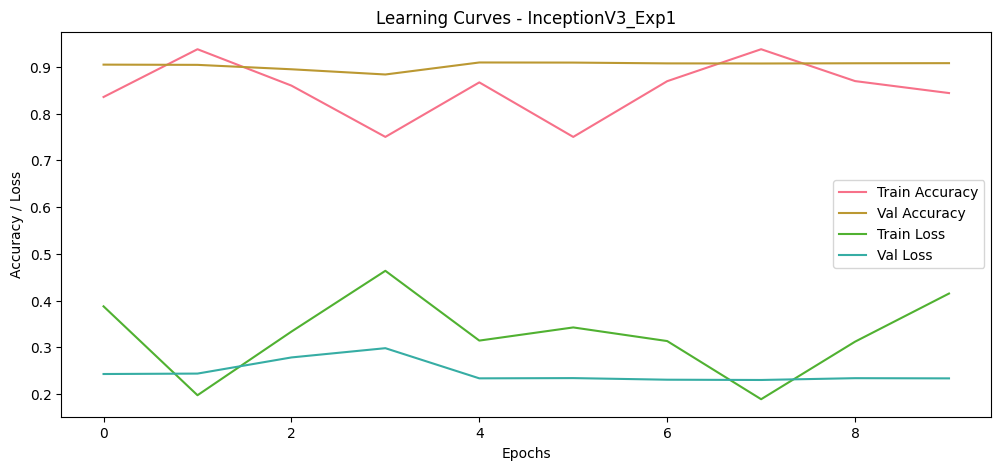

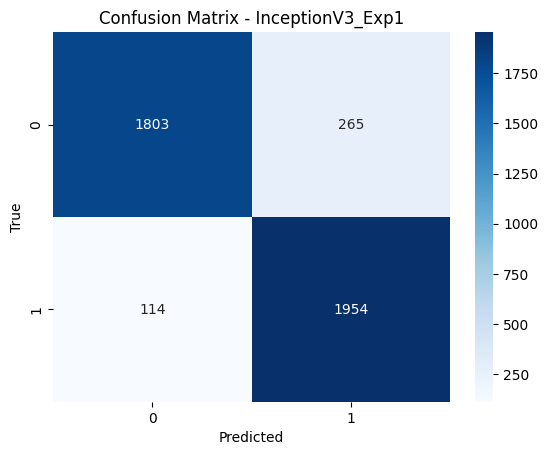

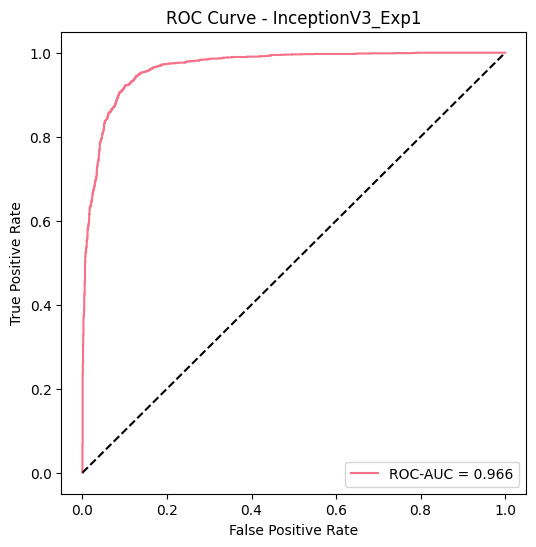


EXPERIMENT 2/2: InceptionV3_Exp2
Description: LR=0.0005, Dropout=0.5, Dense=256, Fine-tune=True, Optimizer=Adam
Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 239s 279ms/step - accuracy: 0.8775 - loss: 0.3248 - val_accuracy: 0.9605 - val_loss: 0.1909 - learning_rate: 5.0000e-04
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9375 - loss: 0.2013 - val_accuracy: 0.9615 - val_loss: 0.1942 - learning_rate: 5.0000e-04
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 188s 225ms/step - accuracy: 0.9328 - loss: 0.2025 - val_accuracy: 0.9479 - val_loss: 0.1582 - learning_rate: 5.0000e-04
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9062 - loss: 0.3714 - val_accuracy: 0.9506 - val_loss: 0.1498 - learning_rate: 5.0000e-04
Epoch 5/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 125s 207ms/step - accuracy: 0.9392 - loss: 0.1805 - val_accuracy: 0.9600 - val_loss: 0.1351 - learning_rate: 5.0000e-04
Epoch 6/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.0000 - loss: 0.0763 - val_acc

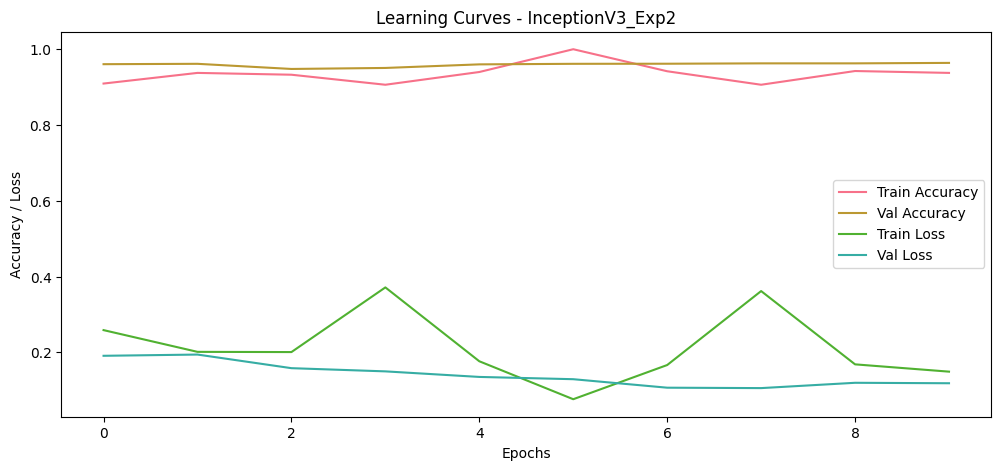

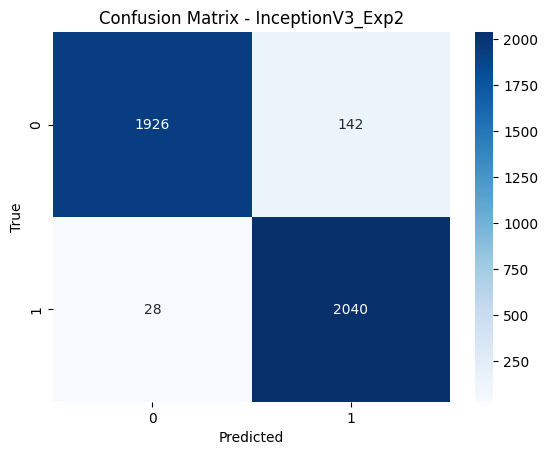

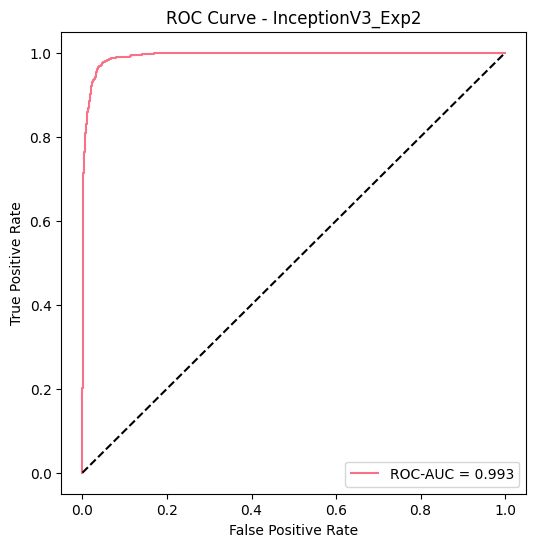

,experiment,accuracy,precision,recall,f1_score,roc_auc
1,InceptionV3_Exp2,0.958897,0.934922,0.986460,0.960000,0.993303
0,InceptionV3_Exp1,0.908366,0.880577,0.944874,0.911593,0.966373


In [39]:
# =====================================================
# InceptionV3 Experimental Suite (2 Experiments)
# =====================================================

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import json
import gc

# -----------------------------
# Dataset paths
# -----------------------------
TRAIN_DIR = '/content/cell_images/train'
VALIDATION_DIR = '/content/cell_images/validation'
TEST_DIR = '/content/cell_images/test'

IMG_HEIGHT, IMG_WIDTH = 128, 128  # Minimum 75x75 for InceptionV3
BATCH_SIZE = 32
# Update steps per epoch based on actual dataset size, not hardcoded values
STEPS_PER_EPOCH = 19290 // BATCH_SIZE # Based on train_generator.samples from cell _wOZHBX4HIIh
VALIDATION_STEPS = 4132 // BATCH_SIZE # Based on validation_generator.samples from cell _wOZHBX4HIIh
TEST_STEPS = 4136 // BATCH_SIZE # Based on test_generator.samples from cell _wOZHBX4HIIh


# -----------------------------
# Data generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode='binary',
    shuffle=False
)

# -----------------------------
# Experiment configurations
# -----------------------------
experiments = [
    {
        "name": "InceptionV3_Exp1",
        "description": "LR=0.001, Dropout=0.3, Dense=128, Fine-tune=False, Optimizer=Adam",
        "learning_rate": 0.001,
        "dropout_rate": 0.3,
        "dense_neurons": 128,
        "fine_tune": False,
        "optimizer": "Adam",
        "epochs": 10
    },
    {
        "name": "InceptionV3_Exp2",
        "description": "LR=0.0005, Dropout=0.5, Dense=256, Fine-tune=True, Optimizer=Adam",
        "learning_rate": 0.0005,
        "dropout_rate": 0.5,
        "dense_neurons": 256,
        "fine_tune": True,
        "optimizer": "Adam",
        "epochs": 10
    }
]

# -----------------------------
# Model creation
# -----------------------------
def create_inception_model(config):
    base_model = InceptionV3(include_top=False, weights='imagenet',
                             input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), pooling='avg')
    if not config['fine_tune']:
        base_model.trainable = False
    else:
        base_model.trainable = True

    x = base_model.output
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(config['dense_neurons'], activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=config['learning_rate']) if config['optimizer'].lower() == 'adam' else SGD(learning_rate=config['learning_rate'], momentum=0.9)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(model, history, config):
    y_true = test_generator.classes
    y_probs = model.predict(test_generator).ravel()
    y_pred = (y_probs > 0.5).astype(int)

    # Classification metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc_val = auc(fpr, tpr)

    print(f"\nClassification Report for {config['name']}:")
    print(classification_report(y_true, y_pred, digits=4))

    # Learning curves
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Learning Curves - {config['name']}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {config['name']}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_val:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {config['name']}")
    plt.legend()
    plt.show()

    return {
        'experiment': config['name'],
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': roc_auc_val,
        'history': history.history,
        'config': config
    }

# -----------------------------
# Run single experiment
# -----------------------------
def run_single_experiment(config, exp_number, total_experiments):
    print(f"\n{'='*80}")
    print(f"EXPERIMENT {exp_number}/{total_experiments}: {config['name']}")
    print(f"{'='*80}")
    print(f"Description: {config['description']}")
    start_time = datetime.now()
    model = create_inception_model(config)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
    ]

    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        epochs=config['epochs'],
        callbacks=callbacks
    )

    results = evaluate_model(model, history, config)
    results['training_duration_minutes'] = (datetime.now() - start_time).total_seconds() / 60
    del model
    gc.collect()
    return results

# -----------------------------
# Run all experiments
# -----------------------------
final_results_list = []
for i, config in enumerate(experiments, 1):
    res = run_single_experiment(config, i, len(experiments))
    final_results_list.append(res)

# Display ranking table
df_results = pd.DataFrame(final_results_list).sort_values('f1_score', ascending=False)
display(df_results[['experiment','accuracy','precision','recall','f1_score','roc_auc']])